# Programming Assignment \#1, Deliverable 6
## Eren Akgunduz

In [1]:
import os
import sys
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

### Logger

The logging system **definitely** came in handy when I was testing my code in the Python script. Although it *does* also work within this notebook, I feel that it's unnecessary and creates clutter for the outputs. In the interest of displaying only the necessary plots and info, I changed the logging level here to warnings only (to keep it quiet).

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

fh = logging.StreamHandler()
fmt = logging.Formatter(
    "%(asctime)s %(levelname)s %(lineno)d:%(filename)s(%(process)d) - %(message)s"
)
fh.setFormatter(fmt)
logger.addHandler(fh)

In [3]:
# grid of tuning parameters represented by lambda
l = np.logspace(-2, 4, 7)

### Functions

In [4]:
def preprocess_data(filename: str) -> tuple:
    "Take in raw data and convert it to a workable format/state"
    if not isinstance(filename, str):
        raise TypeError("Filename should be a string :)")

    try:
        datafile = f"{os.getcwd()}/{filename}"
        logger.debug(datafile)
        if not os.path.exists(datafile):
            raise OSError("Expected data file, didn't find it :/")

        df = pd.read_csv(datafile, sep=",")  # read and pass to dataframe
        # debug shows that scikit-learn has mapped male to 1 and female to 0
        df[["Gender", "Student", "Married"]] = OrdinalEncoder().fit_transform(
            df[["Gender", "Student", "Married"]]
        )
        logger.debug(df[["Gender", "Student", "Married"]].head(10))

        # convert dataframe to numpy array for faster computations
        return (df.columns.to_numpy(), np.array(df))
    except OSError:
        print("Couldn't load in the data due to OS error.")
        sys.exit("Check if things are right and try again :)")

In [5]:
def standardize(data) -> tuple:
    "Establish design matrix and response vector, prepare both for ridge regression"
    y = data[:, 9]  # extract only the data from the output column (balance)
    y = (lambda c: c - c.mean())(y)  # IIFE to center response vector
    logger.debug(y.shape)
    logger.debug(y.mean())

    dm = np.delete(data, 9, axis=1)  # extract the design matrix
    X = StandardScaler().fit_transform(dm)  # standardize (center & scale)

    logger.debug(X.shape)
    logger.debug([np.mean(X[:, k]) for k in range(X.shape[1])])
    logger.debug([np.std(X[:, k]) for k in range(X.shape[1])])
    return (X, y)

In [6]:
def ridge_regression(X, y, l, cv: bool = False, k: int = 5) -> np.ndarray:
    if not isinstance(k, int):
        raise TypeError("Number of folds should be an integer :)")

    coeffs = np.zeros((7, 9))
    cv_errors = []

    def ridge(a):
        ridge = Ridge(alpha=a)
        ridge.fit(X, y)
        return ridge.coef_

    if not isinstance(l, (int, float)):
        for index, val in enumerate(l):
            if cv:
                cv_errors.append(
                    np.abs(
                        cross_val_score(
                            Ridge(alpha=val),
                            X,
                            y,
                            cv=k,
                            scoring="neg_mean_squared_error",
                        )
                    )
                )
            else:
                coeffs[index] = ridge(val)
    else:
        coeffs = ridge(l)

    if cv:
        logger.debug(f"{np.array(cv_errors).shape}\n{np.array(cv_errors)}")
        logger.debug(np.array(cv_errors).mean(axis=1))
        return np.array(cv_errors).mean(axis=1)
    return coeffs

In [7]:
columns, data = preprocess_data("Credit_N400_p9.csv")  # unpack the tuple

### Deliverable \#1

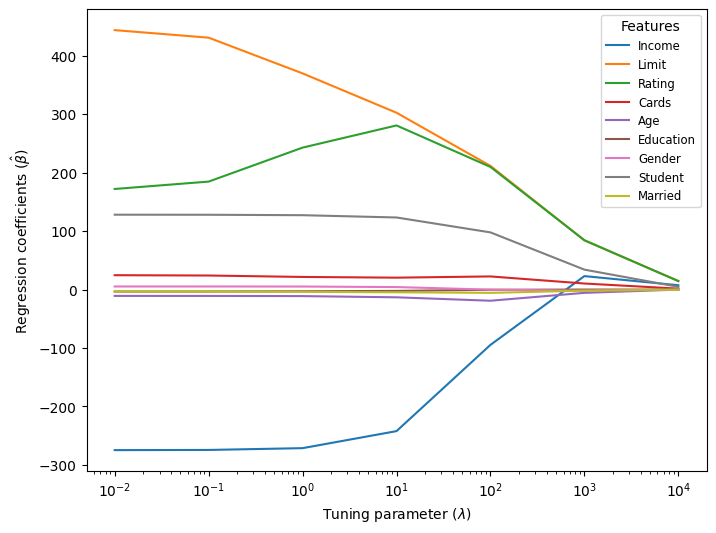

In [8]:
X, y = standardize(data)
# transpose so that each row is one of the nine features with the seven columns for TP
b = ridge_regression(X, y, l).T
# this way, each index (row) has the vector I need to plot points
plt.figure(figsize=(8, 6))
plt.xscale("log")
[plt.plot(l, b, label=f"{columns[i]}") for i, b in enumerate(b)]
plt.xlabel(r"Tuning parameter ($\lambda$)")
plt.ylabel(r"Regression coefficients ($\hat{\beta}$)")
plt.legend(title="Features", fontsize="small")
plt.show()

### Deliverable \#2

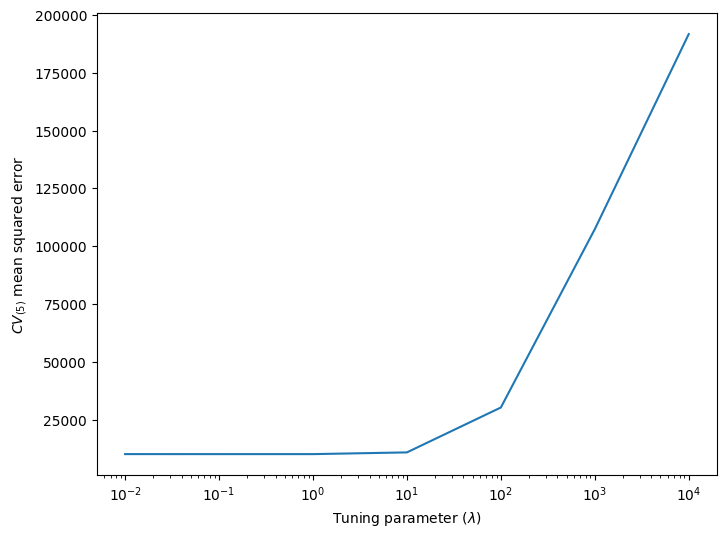

In [9]:
cv_error = ridge_regression(X, y, l, True)
plt.figure(figsize=(8, 6))
plt.xscale("log")
plt.plot(l, cv_error)
plt.xlabel(r"Tuning parameter ($\lambda$)")
plt.ylabel(r"$CV_{(5)}$ mean squared error")
plt.show()

### Deliverable \#3

In [10]:
l_optimal = float(l[cv_error.argmin()])

In [11]:
l_optimal

1.0

### Deliverable \#4

In [12]:
b = ridge_regression(X, y, l_optimal)

In [13]:
b

array([-271.23122766,  369.52441617,  242.60689635,   21.49206153,
        -11.27075014,   -3.04525924,    5.09410044,  127.07827162,
         -3.97552834])